In [1]:
import os
from Network import QNetwork
from Agent import Agent
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import warnings
import grid2op
from grid2op.PlotGrid import PlotMatplot
from lightsim2grid import LightSimBackend
from grid2op.Action import TopologyChangeAction
from grid2op.gym_compat import DiscreteActSpace
from grid2op.gym_compat import GymEnv
import grid2op
from gymnasium import Env
from gymnasium.utils.env_checker import check_env
from Agent import DQNAgent
from utils import obs_to_vect
from collections import deque, namedtuple

c:\Users\Ernest\.conda\envs\l2rpn-test\lib\site-packages\grid2op\Backend\pandaPowerBackend.py:32: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	c:\Users\Ernest\.conda\envs\l2rpn-test\python.exe -m pip install numba

  warnings.warn(


In [2]:
env_name = "rte_case5_example"  # or any other name.
env = grid2op.make(env_name, test=True, action_class=TopologyChangeAction)

c:\Users\Ernest\.conda\envs\l2rpn-test\lib\site-packages\grid2op\MakeEnv\Make.py:438: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


In [3]:
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
env_name = "rte_case5_example"
training_env = grid2op.make(env_name, test=True)  # we put "test=True" in this notebook because...
# it's a notebook to explain things. Of course, do not put "test=True" if you really want
# to train an agent...
gym_env = GymEnv(training_env)

c:\Users\Ernest\.conda\envs\l2rpn-test\lib\site-packages\grid2op\MakeEnv\Make.py:438: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


In [4]:
gym_env.action_space = DiscreteActSpace(training_env.action_space)

In [5]:
HP = {}
HP['BUFFER_SIZE'] = int(1e5)
HP['BATCH_SIZE'] = 128
HP['GAMMA'] = 0.99
HP['TAU'] = 1e-3
HP['LR'] = 5e-4
HP['UPDATE_EVERY'] = 8
HP['GAMMA'] = 0.95
HP['EXPLORATION_MAX'] = 1.0
HP['EXPLORATION_DECAY'] = 0.999
HP['EXPLORATION_MIN'] = 0.001
HP['FC1_DIMS'] = 1024
HP['FC2_DIMS'] = 512
HP['LEARNING_RATE'] = 0.0001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
agent = Agent(state_size=211, action_size=166, seed=1000, HP=HP, device=device)

In [7]:
EPISODES = 1000
episode_number = []
average_reward = 0
average_reward_number = []
best_reward = 0

agent = DQNAgent(gym_env, HP)

for i in range(1, EPISODES):
    state, _ = gym_env.reset()
    score = 0

    while True:
        #env.render()
        action = agent.choose_action(obs_to_vect(state))
        state_, reward, done, info, _ = gym_env.step(action)
        agent.memory.add(obs_to_vect(state), action, reward, obs_to_vect(state_), done)
        agent.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break
            
        episode_number.append(i)
        average_reward_number.append(average_reward/i)


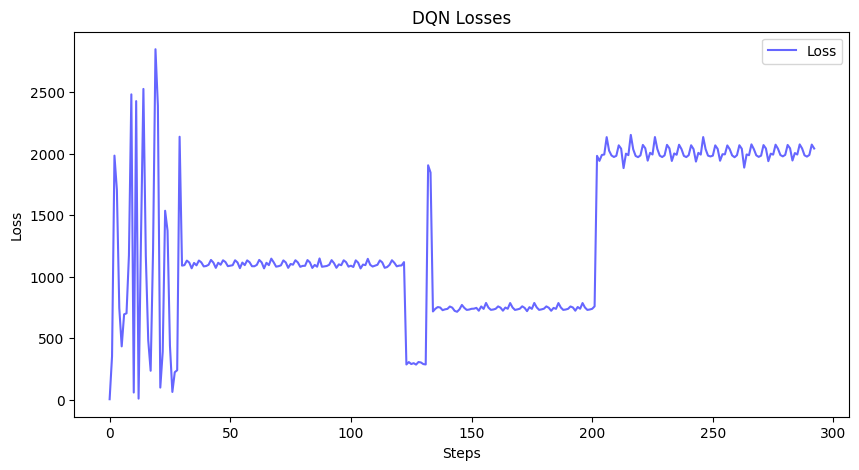

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))  # Rectangle shape

# Plot the losses
ax.plot(average_reward_number, color='blue', alpha=0.6, label='Loss')

# Customize the plot
ax.set_title('DQN Losses')
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.legend()

# Show the plot
plt.show()